In [60]:
from Bio import SeqIO
import numpy as np
import pandas as pd
import copy
import random

### Split train & test dataset

In [2]:
### Load dataset

file_path = {'AMP':'./processing/AMP_c_0.6.fasta',\
             'ACP':'./processing/ACP_c_0.6.fasta',\
             'Negative':'./processing/uniref50_no_redundancy_w_AMP_ACP.fasta'}

In [6]:
sequences = dict()
pep_len = dict()
for tgt, path in file_path.items():
    sequences[tgt] = list()
    pep_len[tgt] = list()
    for seq in SeqIO.parse(path,'fasta'):
        if 'x' not in str(seq.seq) and 'X' not in str(seq.seq):
            sequences[tgt].append(seq) ### SeqRecord append (SeqRecord from Bio)
            pep_len[tgt].append(len(str(seq.seq))) ### Append each peptide sequence length 
        _len = len(sequences[tgt])
    print(f'{tgt} Sequence length: {_len}')

AMP Sequence length: 1636
ACP Sequence length: 542
Negative Sequence length: 288675


In [24]:
seq ### SeqRecord contains sequence, id, name, description information of peptides

SeqRecord(seq=Seq('MAKQGSKGEKG'), id='UniRef50_F1AU43', name='UniRef50_F1AU43', description='UniRef50_F1AU43 Gag polyprotein (Fragment) n=1 Tax=Ovine progressive pneumonia virus TaxID=253923 RepID=F1AU43_9RETR', dbxrefs=[])

### ACP dataset peptide length histogram
- Most of length were enriched under 30 AA residues

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

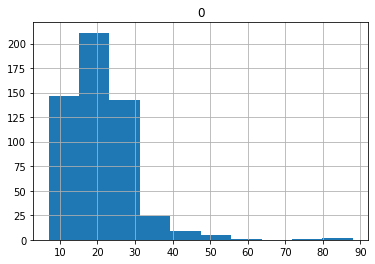

In [20]:
pd.DataFrame(pep_len['ACP']).hist()

### AMP dataset peptide length histogram
- Most of length were enriched under 30 AA residues

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

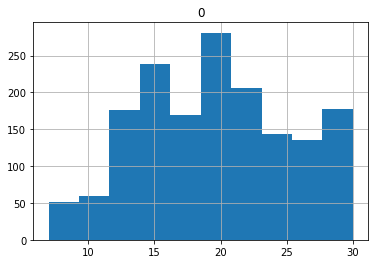

In [19]:
pd.DataFrame(pep_len['AMP']).hist()

### Peptide length cutoff as 30

## Dataset loading

In [83]:
sequences = dict()
pep_len = dict()
for tgt, path in file_path.items():
    sequences[tgt] = list()
    pep_len[tgt] = list()
    for seq in SeqIO.parse(path,'fasta'):
        if 'x' not in str(seq.seq) and 'X' not in str(seq.seq) and len(seq.seq)<=30:
            sequences[tgt].append(seq) ### SeqRecord append (SeqRecord from Bio)
            pep_len[tgt].append(len(str(seq.seq))) ### Append each peptide sequence length 
        _len = len(sequences[tgt])
    print(f'{tgt} Sequence length: {_len}')

AMP Sequence length: 1636
ACP Sequence length: 496
Negative Sequence length: 288675


### Train test dataset split

In [84]:
def nFoldSplit(dat, n_fold):
    data=copy.deepcopy(dat)

    random.shuffle(data)

    nFoldData = list()
    i=0
    while True:
        try:
            temp = data.pop()
            if i//n_fold==0:
                nFoldData.append([temp])
            else:
                idx = i%n_fold
                nFoldData[idx]+=[temp]
            i+=1
        except IndexError:
            break
    return nFoldData

In [85]:
def negative_sampling(neg_data, length):
    random.shuffle(neg_data)
    sampled_data = copy.deepcopy(neg_data[:length])
    neg_data = neg_data[length:]
    return sampled_data, neg_data

In [98]:
tr_seqs = dict()
tr_neg_seqs = dict()
test_seqs = dict()
test_neg_seqs = dict()

test_ratio = 0.3
for tgt in ['AMP','ACP']:
    seq_len = len(sequences[tgt])
    test_len = int(seq_len*test_ratio)
    test_seqs[tgt] = sequences[tgt][:test_len]
    test_neg_seqs[tgt], sequences['Negative'] = negative_sampling(sequences['Negative'], test_len)
    
    tr_seqs[tgt] = nFoldSplit(sequences[tgt][test_len:],n_fold = 5)
    neg_temp, sequences['Negative'] = negative_sampling(sequences['Negative'],seq_len-test_len)
    tr_neg_seqs[tgt] = nFoldSplit(neg_temp, n_fold=5)
    

tot_data = list()
for tgt in ['AMP','ACP']:
    for fold, fold_data in enumerate(tr_seqs[tgt]):
        for seq in fold_data:
            tot_data.append([seq.id, str(seq.seq), 'train', fold, tgt, 1]) ## ID, Sequence, train, n_fold, target, Positive:1

    for fold, fold_data in enumerate(tr_neg_seqs[tgt]):
        for seq in fold_data:
            tot_data.append([seq.id, str(seq.seq), 'train', fold, tgt, 0]) ## ID, Sequence, train, n_fold, target, Negative:0
        
    for seq in test_seqs[tgt]:
        tot_data.append([seq.id, str(seq.seq), 'test', -1, tgt, 1]) ## ID, Sequence, train, n_fold, target, Negative:0

    for seq in test_neg_seqs[tgt]:
        tot_data.append([seq.id, str(seq.seq), 'test', -1, tgt, 0]) ## ID, Sequence, train, n_fold, target, Negative:0
        

    

In [99]:
pd.DataFrame(tot_data, columns=['ID', 'Sequence', 'Train/test', 'Num Fold', 'Target', 'Pos/Neg']).to_csv('./train_dataset/amp_acp_dataset.csv', index=None)

In [100]:
temp = pd.DataFrame(tot_data, columns=['ID', 'Sequence', 'Train/test', 'Num Fold', 'Target', 'Pos/Neg'])

In [101]:
#Final Dataset info
temp.groupby(['Train/test', 'Target', 'Pos/Neg']).size()

Train/test  Target  Pos/Neg
test        ACP     0           148
                    1           148
            AMP     0           490
                    1           490
train       ACP     0           348
                    1           348
            AMP     0          1146
                    1          1146
dtype: int64